In [1]:
import os
import subprocess
import geomstats.backend as gs

geomstats_gitroot_path = subprocess.check_output(
    ["git", "rev-parse", "--show-toplevel"], universal_newlines=True
)
os.chdir(geomstats_gitroot_path[:-1])
print("Working directory: ", os.getcwd())

import warnings
warnings.filterwarnings("ignore")

import sys
sys_dir = os.path.dirname(os.getcwd())
sys.path.append(sys_dir)
print("Directory added to path: ", sys_dir)


a = gs.array([1., 2.])
print("\nFloat precision:", a.dtype)

INFO: Using numpy backend


Working directory:  /home/wanxinli/dyn
Directory added to path:  /home/wanxinli

Float precision: float64


In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [3]:
from scipy import stats

from sklearn.cluster import KMeans
from sklearn.metrics import confusion_matrix
from sklearn.decomposition import PCA

from scipy.optimize import linear_sum_assignment as linear_assignment
from sklearn import manifold
from joblib import Parallel, delayed
from numba import jit, njit, prange

In [4]:
from geomstats.geometry.euclidean import Euclidean
from geomstats.geometry.discrete_curves import DiscreteCurves, ClosedDiscreteCurves

from geomstats.learning.frechet_mean import FrechetMean
from geomstats.learning.kmeans import RiemannianKMeans
# from geomstats.learning.mdm import RiemannianMinimumDistanceToMeanClassifier
from geomstats.learning.pca import TangentPCA

import dyn.dyn.datasets.experimental as experimental
# import dyn.dyn.features.basic as basic
# import dyn.viz as viz

# viz.init_matplotlib()
# %config InlineBackend.figure_formats = ['svg']

In [5]:
dataset_name = "osteosarcoma" #  "retinal"
assert dataset_name in ["osteosarcoma", "retinal"]

if dataset_name == "osteosarcoma":
    n_cells = 650
    n_sampling_points = 100
    labels_a_name = "lines"
    labels_b_name = "treatments"
elif dataset_name == "retinal":
    n_cells = 3871
    n_sampling_points = 100
    labels_a_name = "surfaces"
    labels_b_name = "mutations"

quotient = ["rotation"] #["scaling"] #, "rotation"]
do_not_quotient = False

SAVEFIG = True
if SAVEFIG:
    figs_dir = os.path.join(os.getcwd(), f"dyn/saved_figs/{dataset_name}")
    print(f"Will save figs to {figs_dir}")
    from datetime import datetime

    now = datetime.now().strftime("%Y%m%d_%H:%M:%S")
    print(now)

Will save figs to /home/wanxinli/dyn/dyn/saved_figs/osteosarcoma
20230514_02:15:17


In [6]:
print(quotient)
print(do_not_quotient)

['rotation']
False


In [7]:
if dataset_name == "osteosarcoma":
    cells, cell_shapes, labels_a, labels_b = experimental.load_treated_osteosarcoma_cells(
        n_cells=n_cells, n_sampling_points=n_sampling_points, quotient=quotient
    )
else:
    cells, cell_shapes, labels_a, labels_b = experimental.load_mutated_retinal_cells(
        n_cells=n_cells, n_sampling_points=n_sampling_points, quotient=quotient
    )

... Selecting only a random subset of 650 / 650 cells.
... Interpolating: Cell boundaries have 100 samplings points.
... Removing potential duplicate sampling points on cell boundaries.

- Cells: quotienting translation.
- Cell shapes: quotienting rotation.


AttributeError: 'PreShapeSpaceBundle' object has no attribute 'embedding_metric'

In [ ]:
labels_a_dict = {lab: i_lab for i_lab, lab in enumerate(np.unique(labels_a))}
labels_b_dict = {lab: i_lab for i_lab, lab in enumerate(np.unique(labels_b))}

print(f"Dictionary associated to label \"{labels_a_name}\":")
print(labels_a_dict)
print(f"Dictionary associated to label \"{labels_b_name}\":")
print(labels_b_dict)

In [ ]:
if do_not_quotient:
    cell_shapes = cells

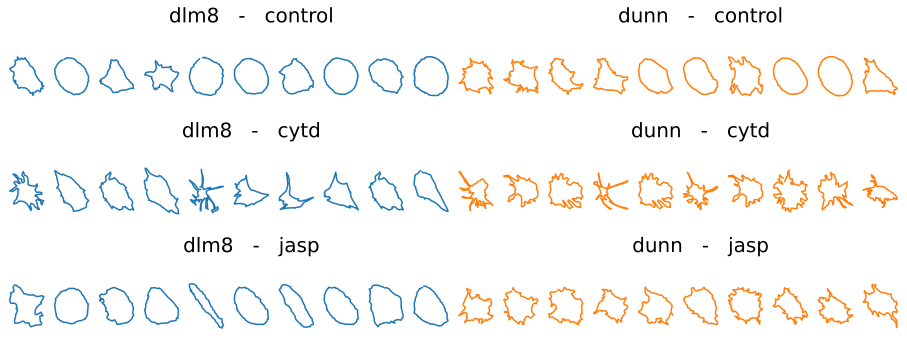

In [ ]:
n_cells_to_plot = 10

fig = plt.figure(figsize=(16, 6))
count = 1
for label_b in np.unique(labels_b):
    for i_lab_a, label_a in enumerate(np.unique(labels_a)):
        cell_data = [cell for cell, lab_a, lab_b in zip(cell_shapes, labels_a, labels_b) if lab_a == label_a and lab_b == label_b]
        for i_to_plot in range(n_cells_to_plot):
            cell = gs.random.choice(cell_data)
            fig.add_subplot(len(np.unique(labels_b)), len(np.unique(labels_a)) * n_cells_to_plot, count)
            count += 1
            plt.plot(cell[:, 0], cell[:, 1], color=f"C{i_lab_a}" )
            plt.axis("equal")
            plt.axis("off")
            if i_to_plot == n_cells_to_plot // 2:
                plt.title(f"{label_a}   -   {label_b}", fontsize=20)
if SAVEFIG:
    plt.savefig(os.path.join(figs_dir, f"{now}_sample_cells.svg"))

In [ ]:
R1 = Euclidean(dim=1)
R2 = Euclidean(dim=2)
CLOSED_CURVES_SPACE = ClosedDiscreteCurves(R2)
CURVES_SPACE = DiscreteCurves(R2)
# SRV_METRIC = CURVES_SPACE.srv_metric
SRV_METRIC = CLOSED_CURVES_SPACE .embedding_space.metric
# L2_METRIC = CURVES_SPACE.l2_curves_metric

ELASTIC_METRIC = {}
AS = [1, 2, 0.75, 0.5, 0.25, 0.01] #, 1.6] #, 1.4, 1.2, 1, 0.5, 0.2, 0.1]
BS = [0.5, 1, 0.5, 0.5, 0.5, 0.5] #, 2, 2, 2, 2, 2, 2, 2]
for a, b in zip(AS, BS):
    ELASTIC_METRIC[a, b] = DiscreteCurves(R2, a=a, b=b).elastic_metric
METRICS = {}
METRICS["Linear"] = L2_METRIC
METRICS["SRV"] = SRV_METRIC

here
here


TypeError: __init__() got an unexpected keyword argument 'a'

In [ ]:
means = {}

means["Linear"] = gs.mean(cell_shapes, axis=0)
means["SRV"] = FrechetMean(
        metric=SRV_METRIC, 
        method="default").fit(cell_shapes).estimate_

In [ ]:
for a, b in zip(AS, BS):
    means[a, b] = FrechetMean(
            metric=ELASTIC_METRIC[a, b], 
            method="default").fit(cell_shapes).estimate_

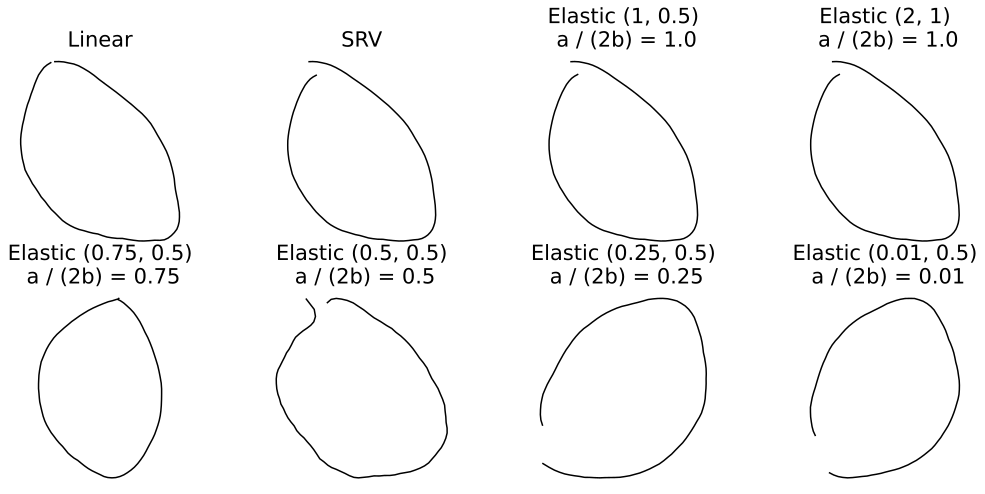

In [ ]:
fig = plt.figure(figsize=(18, 8))

ncols = len(means) // 2

for i, (mean_name, mean) in enumerate(means.items()):
    ax = fig.add_subplot(2, ncols, i+1)
    ax.plot(mean[:, 0], mean[:, 1], "black")
    ax.set_aspect("equal")
    ax.axis("off")
    axs_title = mean_name
    if mean_name not in ["Linear", "SRV"]:
        a = mean_name[0]
        b = mean_name[1]
        ratio = a / (2 * b)
        mean_name = f"Elastic {mean_name}\n a / (2b) = {ratio}"
    ax.set_title(mean_name)
    
if SAVEFIG:
    plt.savefig(os.path.join(figs_dir, f"{now}_open_means.svg"))

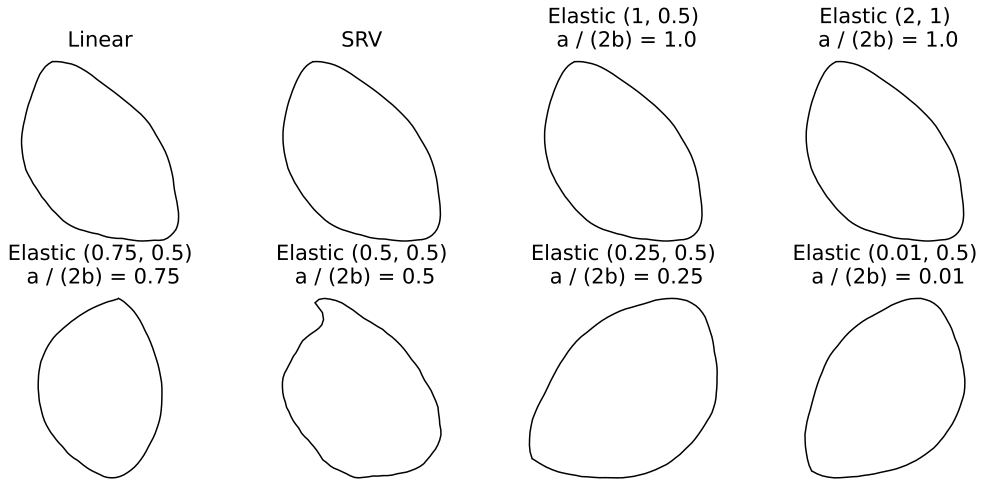

In [ ]:
fig = plt.figure(figsize=(18, 8))

ncols = len(means) // 2

for i, (mean_name, mean) in enumerate(means.items()):
    ax = fig.add_subplot(2, ncols, i+1)
    mean = CLOSED_CURVES_SPACE.projection(mean)
    ax.plot(mean[:, 0], mean[:, 1], "black")
    ax.set_aspect("equal")
    ax.axis("off")
    axs_title = mean_name
    if mean_name not in ["Linear", "SRV"]:
        a = mean_name[0]
        b = mean_name[1]
        ratio = a / (2 * b)
        mean_name = f"Elastic {mean_name}\n a / (2b) = {ratio}"
    ax.set_title(mean_name)
if SAVEFIG:
    plt.savefig(os.path.join(figs_dir, f"{now}_closed_means.svg"))